<a href="https://colab.research.google.com/github/jenniferamhajduk/AIML_Playground/blob/main/Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@InProceedings{cimpoi14describing,
	      Author    = {M. Cimpoi and S. Maji and I. Kokkinos and S. Mohamed and and A. Vedaldi},
	      Title     = {Describing Textures in the Wild},
	      Booktitle = {Proceedings of the {IEEE} Conf. on Computer Vision and Pattern Recognition ({CVPR})},
	      Year      = {2014}}

In [1]:
!pip install torchrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.6/429.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.6/339.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 65.8 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision.transforms import ToTensor, transforms
from torchvision import datasets
from torch.utils.data import DataLoader
torch.__version__

'2.1.0+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
BATCH_SIZE=32
EPOCHS=10

In [5]:
!nvidia-smi

Thu Feb 29 04:04:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
transform = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor()
])

In [7]:
train_data = datasets.DTD(
    root="data",
    split="train",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

test_data = datasets.DTD(
    root="data",
    split="test",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

val_data = datasets.DTD(
    root="data",
    split="val",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

100%|██████████| 625239812/625239812 [00:02<00:00, 229968948.46it/s]


Extracting data/dtd/dtd-r1.0.1.tar.gz to data/dtd


In [8]:
len(train_data), len(test_data), len(val_data)

(1880, 1880, 1880)

In [9]:
image, target = train_data[0]

In [10]:
image, target

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.0039, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0039],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0039],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0039, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0078, 0.0039, 0.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4941, 0.4980, 0.4941],
          [1.0000, 1.0000, 1.0000,  ..., 0.4941, 0.4941, 0.4902],
          [1.0000, 1.0000, 1.0000,  ...,

In [11]:
image.shape

torch.Size([3, 640, 480])

In [12]:
classes = train_data.classes
classes

['banded',
 'blotchy',
 'braided',
 'bubbly',
 'bumpy',
 'chequered',
 'cobwebbed',
 'cracked',
 'crosshatched',
 'crystalline',
 'dotted',
 'fibrous',
 'flecked',
 'freckled',
 'frilly',
 'gauzy',
 'grid',
 'grooved',
 'honeycombed',
 'interlaced',
 'knitted',
 'lacelike',
 'lined',
 'marbled',
 'matted',
 'meshed',
 'paisley',
 'perforated',
 'pitted',
 'pleated',
 'polka-dotted',
 'porous',
 'potholed',
 'scaly',
 'smeared',
 'spiralled',
 'sprinkled',
 'stained',
 'stratified',
 'striped',
 'studded',
 'swirly',
 'veined',
 'waffled',
 'woven',
 'wrinkled',
 'zigzagged']

In [13]:
len(classes)

47

Text(0.5, 1.0, 'braided')

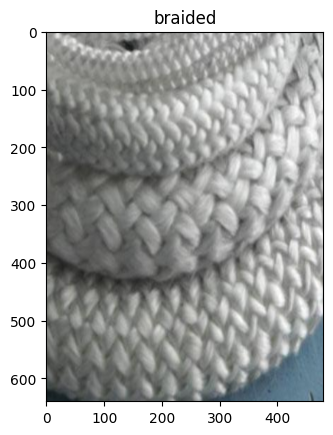

In [14]:
image, label = train_data[100]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose(1,2,0)
plt.imshow(image)
plt.title(classes[label])

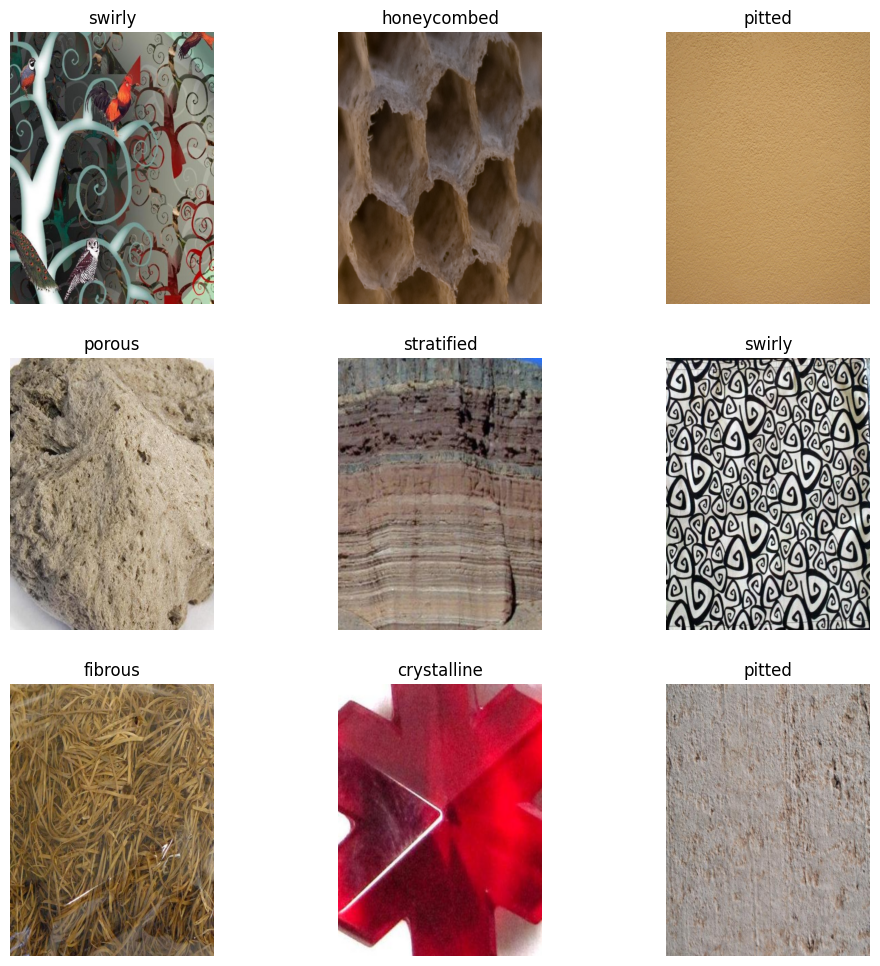

In [17]:
fig = plt.figure(figsize=(12,12))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[rand_idx]
  image = image.numpy()
  image = image.transpose(1,2,0)
  fig.add_subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(classes[label])
  plt.axis(False)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)